In [1]:
%load_ext autoreload
%autoreload 2
%cd ../
from utils.modules import Modules
from run_before_script import run
run()

/home/projects/schneidmann/royu/thesis/unsup_neur


In [2]:
from vision.utils.figures_utils import EXTENDED_QS
from vision.evaluate import EVAL_ENS_LIN, EVAL_IND_LIN, EVAL_ENS_LIN_NAME, EVAL_IND_LIN_NAME
from utils.figure_utils import gather_results_over_all_args
from utils.figure_utils import plot_lines_different_along_q as plot_along_q
from utils.plot_utils import *
from matplotlib import pyplot as plt
from utils.measures.utils import CrossPathMeasures
from utils.utils import paired_t_test, ind_permutation_test
import numpy as np
import os

In [3]:
stop_q = np.where(np.array(EXTENDED_QS) == 0.3)[0][0]
LESS_EXTENDED_QS = EXTENDED_QS[:stop_q]
QS_GAUS = np.array([0.01] + LESS_EXTENDED_QS)
q_index = 4
q_index_rand = 1
chosen_q = QS_GAUS[q_index]
chosen_q_rand = EXTENDED_QS[q_index_rand]


SEEDS = np.arange(1, 11)
N = 10
NS = np.array([2,3,5,10,15])

LABEL_GAUS = "Gaussian masking"
LABEL_GAUS_TITLE = LABEL_GAUS
LABEL_RAND = "Random patches masking"
LABEL_RAND_TITLE = LABEL_RAND.lower()

model_basic_format = "fc_nopatch_actual_gaus2_{N}_fixed_d{d}_seed{seed}_1024_512_256_out256"
ending = "_encperpath"
closer_ending = "_actualmse_log_noreg"
model_format = model_basic_format.format(N=N, d="{d}", seed="{seed}") + ending
model_format_N = model_basic_format + ending
model_format_N_closer = model_format_N + closer_ending
model_format_untrained = model_format + "_untrained"
model_format_closer = model_format + closer_ending
model_format_sup = model_format + "_pathsup"



model_basic_format_rand = "fc_nopatchenc_{N}_fixed_d{d}_seed{seed}_1024_512_256_out256"
closer_ending_rand = "_actualmse_log_noreg"
model_format_rand = model_basic_format_rand.format(N=N, d="{d}", seed="{seed}") + ending
model_format_N_rand = model_basic_format_rand + ending
model_format_N_closer_rand = model_format_N_rand + closer_ending_rand
model_format_untrained_rand = model_format_rand + "_untrained"
model_format_closer_rand = model_format_rand + closer_ending_rand
model_format_sup_rand = model_format_rand + "_pathsup"

task_ind = EVAL_IND_LIN
task_ind_imgs = "image_" + task_ind
task_ens = EVAL_ENS_LIN

SINGLE_ENCODER_TITLE = "Single encoder"
ENSEMBLE_TITLE = "Ensemble"
font_size = 12

less_extended_ticks = lambda ax=None: (plt.xticks if ax is None else ax.set_xticks)(np.linspace(0, 0.3, 4), [f"{v:.1f}" if v > 0 else "0" for v in np.linspace(0, 0.3, 4)], size=font_size)

In [4]:
full_img_baseline = Modules.VISION.load_evaluation_json((model_basic_format + ending).format(N=1, d=1, seed=1) + "_untrained")[task_ind_imgs][-1]

In [5]:
SAVE = True

FIGURES_DIR = 'figures/'
os.makedirs(FIGURES_DIR, exist_ok=True)
def savefig(fn, fignum=None, suffix='svg'):
    if SAVE:
        from utils.plot_utils import savefig as orig_savefig
        cur_path = os.path.join(*([FIGURES_DIR] + ([str(fignum)] if fignum is not None else []) + [fn]))
        os.makedirs(os.path.join(*cur_path.split("/")[:-1]), exist_ok=True)
        orig_savefig(cur_path, suffix=suffix)

In [6]:
def ticksize(ax, font_size=font_size):
    ax.tick_params(labelsize=font_size)    

def set_num_ticks(ax, n=5):
    ax.yaxis.set_major_locator(plt.MaxNLocator(n))

# Figure 1

## Figure 1a

In [7]:
def mask_patch_to_image(img, model, p=0, return_mask=False):
    num_patches = model.get_layer(model.name + '_pathways').num_patches
    indices_shape = [int(np.sqrt(num_patches))]*2
    indices = np.indices(indices_shape).reshape(2, -1)
    
    mask = np.full(img.shape[:-1], False)
    pathways = model.get_layer(model.name + f"_pathways")
    if Modules.VISION.load_json(model.name, config=True)['model_kwargs'].get("divide_patches", True):
        patch_size = model.get_layer(model.name + '_patch').patch_size
    else:
        patch_size = 1
    for ind in (pathways.indices.numpy()[:, p] - pathways.shift):
        mask[patch_size * indices[0, ind]:patch_size * (indices[0, ind] + 1), 
             patch_size * indices[1, ind]:patch_size * (indices[1, ind] + 1)] = True
    if return_mask:
        return mask
    return np.where(mask[..., None], img, np.nan)

In [8]:
from vision.utils.data import Cifar10

def plot_imshow_masked(img, model_name=None, p=0, model=None, cmap=None, plot_mask=False):
    if model is None:
        if model_name is not None:
            model = load_model_from_json(model_name, module=Modules.VISION, load=False)
        else:
            model = None
    plt.figure(figsize=(3,3))
    plt.imshow(mask_patch_to_image(img/256, model, p=p, return_mask=plot_mask) if model is not None else img, cmap=cmap if (cmap or not plot_mask) else 'binary')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

2025-08-25 16:44:38.807371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/share/lsf/10.1/linux3.10-glibc2.17-x86_64/lib
2025-08-25 16:44:38.807405: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-08-25 16:44:38.807436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cn819.wexac.weizmann.ac.il): /proc/driver/nvidia/version does not exist
2025-08-25 16:44:38.807707: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
splitting randomly
saved figure as figures/1/a_17673.svg
saved figure as figures/1/a_17673_0.svg
saved figure as figures/1/a_mask_0.svg
saved figure as figures/1/a_17673_1.svg
saved figure as figures/1/a_mask_1.svg
saved figure as figures/1/a_17673_2.svg
saved figure as figures/1/a_mask_2.svg
saved figure as figures/1/a_17673_3.svg
saved figure as figures/1/a_mask_3.svg
saved figure as figures/1/a_17673_4.svg
saved figure as figures/1/a_mask_4.svg
saved figure as figures/1/a_17673_5.svg
saved figure as figures/1/a_mask_5.svg
saved figure as figures/1/a_17673_6.svg
saved figure as figures/1/a_mask_6.svg
saved figure as figures/1/a_17673_7.svg
saved figure as figures/1/a_mask_7.svg
saved figure as figures/1/a_17673_8.svg
saved figure as figures/1/a_mask_8.svg
saved figure as figures/1/a_17673_9.svg
saved figure as figures/1/a_mask_9.svg
saved figure as figures/1/a_40061.svg
saved figure as figures/1/a_40061_0.svg
saved figure as fi

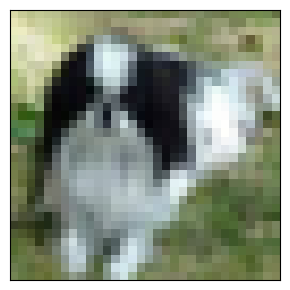

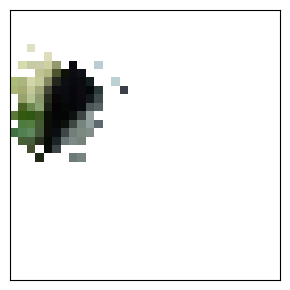

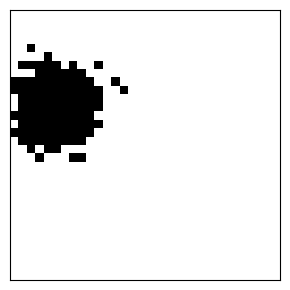

In [9]:
from utils.model.model import load_model_from_json
model = load_model_from_json(model_format_closer.format(seed=1, d=0.1), module=Modules.VISION, load=False)

ds = Cifar10(split=True)
np.random.seed(10)
for i in range(5):
    img_ind = np.random.randint(len(ds.get_x_train()))
    img = ds.get_x_train()[img_ind]
    plot_imshow_masked(img)    
    savefig(f"a_{img_ind}", 1)
    if i: plt.close()
    for p in range(N):
        plot_imshow_masked(img, model=model, p=p)
        savefig(f"a_{img_ind}_{p}", 1)
        if p or i: plt.close()
            
        plot_imshow_masked(img, model=model, p=p, plot_mask=True)
        savefig(f"a_mask_{p}", 1)
        if p or i: plt.close()

# Figure 2

## Figure 2a

In [10]:
from cls_likelihood import calculate_class_mean_likelihood

In [11]:
class NameWrapper:
    def __init__(self, name):
        self.name = name

In [12]:
model_name_base = "fc_nopatch_actual_gaus2_10_fixed_d{d}_seed{seed}_1024_512_256_out256_encperpath"
inp = False

In [13]:
from vision.utils.data import Cifar10
labels = Cifar10.LABELS
ordering = np.array([1, 9, 8, 0, 2, 4, 6, 3, 5, 7])

In [14]:
def plot_cls_mean_like(models, titles, inps, n_paths=10, size=10, cmaps='Reds', normalize=False, save=True):
    if isinstance(cmaps, str):
        cmaps = [cmaps]*len(models)
    arrs = np.stack([calculate_class_mean_likelihood(NameWrapper(model_name), Modules.VISION, inp=inp) for model_name, inp in zip(models, inps)], axis=0)
    if normalize:
        arrs = arrs / arrs.sum(axis=2, keepdims=True)
    for p in range(n_paths):
        vmin, vmax = get_min_max(arrs[..., p])
        fig, axs = plt.subplots(1, len(models), figsize=(4*len(models), 4))
        for i in range(len(models)):
            ax = axs[i] if len(models) > 1 else axs
            colorbar(ax.imshow(arrs[i][ordering][:, ordering][..., p], origin='lower', cmap=cmaps[i], vmin=vmin, vmax=vmax)).set_label(r"$\langle$conditional pseduo-likelihood$\rangle$", 
                                                                                                                                       size=size*1.2)
            ax.set_xticks(np.arange(len(labels)), labels[ordering], rotation=45, size=size, ha='right')
            ax.set_yticks(np.arange(len(labels)), labels[ordering], size=size)
            ax.set_title(titles[i], size=size*1.5)
        plt.tight_layout()

        if save: savefig(f"cls_like/encoder{p}", 2)
        if not p:
            savefig("a", 2)
            plt.show()
        else:
            plt.close()

saved figure as figures/2/cls_like/encoder0.svg
saved figure as figures/2/a.svg


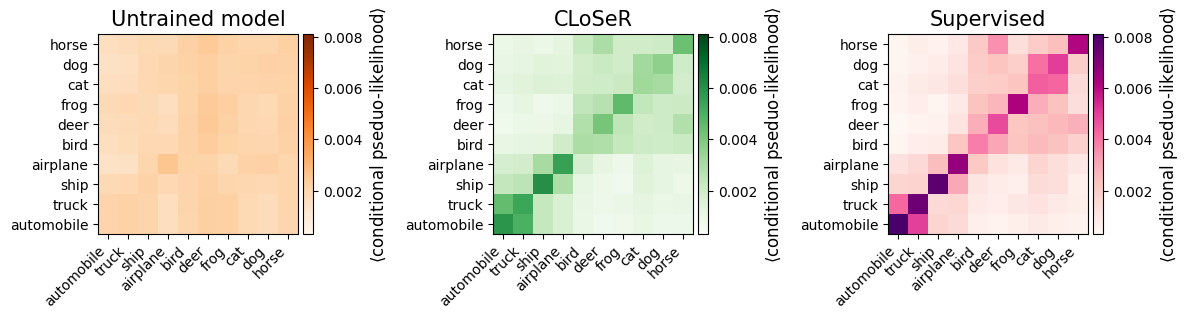

saved figure as figures/2/cls_like/encoder1.svg
saved figure as figures/2/cls_like/encoder2.svg
saved figure as figures/2/cls_like/encoder3.svg
saved figure as figures/2/cls_like/encoder4.svg
saved figure as figures/2/cls_like/encoder5.svg
saved figure as figures/2/cls_like/encoder6.svg
saved figure as figures/2/cls_like/encoder7.svg
saved figure as figures/2/cls_like/encoder8.svg
saved figure as figures/2/cls_like/encoder9.svg


In [15]:
seed = 3
plot_cls_mean_like([
    model_format_untrained.format(seed=seed, d=chosen_q), 
    model_format_closer.format(seed=seed, d=chosen_q),
    model_format_sup.format(seed=seed, d=chosen_q)
                   ], 
    [
        NamesAndColors.UNTRAINED.value.name, 
        NamesAndColors.UNSUPERVISED.value.name,
        NamesAndColors.SUPERVISED.value.name
    ],
    [
        False, 
        False, 
        False
    ], 
    n_paths=10, size=10, 
    cmaps=[
        "Oranges", 
        "Greens", 
        "RdPu"
    ], 
    normalize=False, save=True)

## Figure 2b

In [16]:
def gather_all_paths(m_format, inp=False, single=True, print_missing=True, mean=False, qs=QS_GAUS):
    arr = np.stack([gather_results_over_all_args(m_format, {"d": qs}, 
                                                 module=Modules.VISION, seeds=SEEDS, 
                                                 name="image_"*inp + ((EVAL_IND_LIN if mean else f'pathway{i}_linear') if single else EVAL_ENS_LIN), 
                                                 print_missing=print_missing)
                    for i in range(N if single and not mean else 1)], axis=-2)[..., -1]
    if not single: arr = arr[..., 0]
    return arr

In [17]:
dct_all_paths = {
    NamesAndColors.MASKED.value: gather_all_paths(model_format_untrained, inp=True),
    NamesAndColors.UNTRAINED.value: gather_all_paths(model_format_untrained),
    NamesAndColors.UNSUPERVISED.value: gather_all_paths(model_format_closer),
    NamesAndColors.SUPERVISED.value: gather_all_paths(model_format_sup),
}

In [18]:
width = 4
capsize = 5
height = 4.5

saved figure as figures/2/b.svg


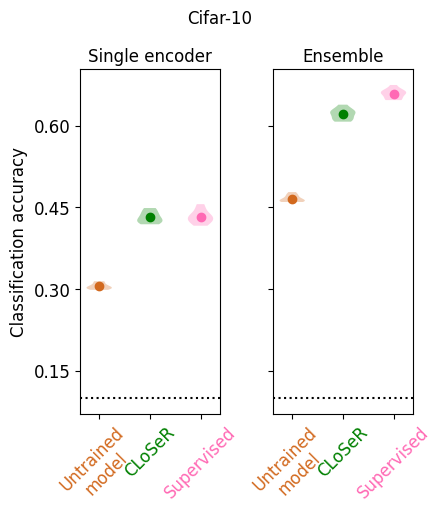

In [19]:
dct_mean_single = {
    nc.value: gather_all_paths(form, single=True, mean=True, qs=np.array([chosen_q])).flatten()
    for nc, form in zip([NamesAndColors.UNTRAINED, NamesAndColors.UNSUPERVISED, NamesAndColors.SUPERVISED],
                        [model_format_untrained, model_format_closer, model_format_sup])
}

dct_ensemble = {
    nc.value: gather_all_paths(form, single=False, mean=True, qs=np.array([chosen_q])).flatten()
    for nc, form in zip([NamesAndColors.UNTRAINED, NamesAndColors.UNSUPERVISED, NamesAndColors.SUPERVISED],
                        [model_format_untrained, model_format_closer, model_format_sup])
}

fig, axs = plt.subplots(1,2, figsize=(4.5,height+0.75), sharey=True)
ax = plt.subplot(121)
plt.title(SINGLE_ENCODER_TITLE, size=font_size)
dct_to_multiviolin({'\n'.join(k.name.split()): v for k, v in dct_mean_single.items()}, 
                   c={'\n'.join(k.name.split()): k.color for k, v in dct_mean_single.items()},
                   ax=ax, rotation=45, plot_CI=False, color_ticklabels=True)
YLABEL_CLASS_F(ax=ax, size=font_size)
ticksize(ax)
set_num_ticks(ax)
plt.axhline(1/10, c='k', linestyle=':')


ax = plt.subplot(122)
plt.title(ENSEMBLE_TITLE, size=font_size)
dct_to_multiviolin({'\n'.join(k.name.split()): v for k, v in dct_ensemble.items()}, 
                   c={'\n'.join(k.name.split()): k.color for k, v in dct_ensemble.items()},
                   ax=ax, rotation=45, plot_CI=False, color_ticklabels=True)
ticksize(ax)
plt.axhline(1/10, c='k', linestyle=':')

plt.suptitle("Cifar-10")
plt.tight_layout()
savefig("b", 2)

saved figure as figures/2/c.svg


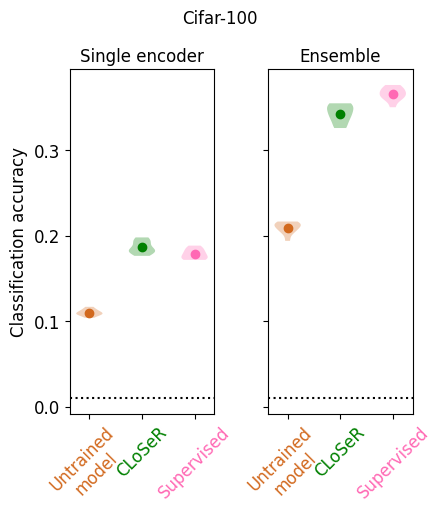

In [20]:
cifar100_end = "_cifar100"

dct_mean_single_cifar100 = {
    nc.value: gather_all_paths(form + cifar100_end, single=True, mean=True, qs=np.array([chosen_q])).flatten()
    for nc, form in zip([NamesAndColors.UNTRAINED, NamesAndColors.UNSUPERVISED, NamesAndColors.SUPERVISED],
                        [model_format_untrained, model_format_closer, model_format_sup])
}

dct_ensemble_cifar100 = {
    nc.value: gather_all_paths(form + cifar100_end, single=False, mean=True, qs=np.array([chosen_q])).flatten()
    for nc, form in zip([NamesAndColors.UNTRAINED, NamesAndColors.UNSUPERVISED, NamesAndColors.SUPERVISED],
                        [model_format_untrained, model_format_closer, model_format_sup])
}

fig, axs = plt.subplots(1,2, figsize=(4.5,height+0.75), sharey=True)
ax = plt.subplot(121)
plt.title(SINGLE_ENCODER_TITLE, size=font_size)
dct_to_multiviolin({'\n'.join(k.name.split()): v for k, v in dct_mean_single_cifar100.items()}, 
                   c={'\n'.join(k.name.split()): k.color for k, v in dct_mean_single_cifar100.items()},
                   ax=ax, rotation=45, plot_CI=False, color_ticklabels=True)
YLABEL_CLASS_F(ax=ax, size=font_size)
plt.axhline(1/100, c='k', linestyle=':')
ticksize(ax)
set_num_ticks(ax)


ax = plt.subplot(122)
plt.title(ENSEMBLE_TITLE, size=font_size)
dct_to_multiviolin({'\n'.join(k.name.split()): v for k, v in dct_ensemble_cifar100.items()}, 
                   c={'\n'.join(k.name.split()): k.color for k, v in dct_ensemble_cifar100.items()},
                   ax=ax, rotation=45, plot_CI=False, color_ticklabels=True)
ticksize(ax)
plt.axhline(1/100, c='k', linestyle=':')

plt.suptitle("Cifar-100")
plt.tight_layout()
savefig("c", 2)

## Figure 2d

In [21]:
from utils.plot_utils import plot_with_CI
common_kwargs = dict(module=Modules.VISION, args={}, seeds=SEEDS, print_missing=True)

none_to_arr = lambda x: np.full((10, 3), np.nan) if x is None else x

unsupervised_results_N = np.stack([none_to_arr(gather_results_over_all_args(model_format_N_closer.format(d=chosen_q, seed='{seed}', N=n), 
                                                                name=task_ind, **common_kwargs)) for n in NS])

supervised_results_N = np.stack([gather_results_over_all_args(model_format_N.format(d=chosen_q, seed='{seed}', N=N) + "_pathsup", 
                                                              name=task_ind, **common_kwargs)] * len(NS))

untrained_results_N = np.stack([gather_results_over_all_args(model_format_N.format(d=chosen_q, seed='{seed}', N=N) + "_untrained", 
                                                             name=task_ind, **common_kwargs)] * len(NS))

img_results_N = np.stack([gather_results_over_all_args(model_format_N.format(d=chosen_q, seed='{seed}', N=N) + "_untrained", 
                                                       name=task_ind_imgs, **common_kwargs)] * len(NS))

unsupervised_results_N_rand = np.stack([gather_results_over_all_args(model_format_N_closer_rand.format(d=chosen_q_rand, seed='{seed}', N=n), 
                                                                     name=task_ind, **common_kwargs) for n in NS])

supervised_results_N_rand = np.stack([gather_results_over_all_args(model_format_N_rand.format(d=chosen_q_rand, seed='{seed}', N=N) + "_pathsup", 
                                                              name=task_ind, **common_kwargs)] * len(NS))

untrained_results_N_rand = np.stack([gather_results_over_all_args(model_format_N_rand.format(d=chosen_q_rand, seed='{seed}', N=N) + "_untrained", 
                                                             name=task_ind, **common_kwargs)] * len(NS))

img_results_N_rand = np.stack([gather_results_over_all_args(model_format_N_rand.format(d=chosen_q_rand, seed='{seed}', N=N) + "_untrained", 
                                                       name=task_ind_imgs, **common_kwargs)] * len(NS))

saved figure as figures/2/d.svg
saved figure as figures/2/d_rand.svg


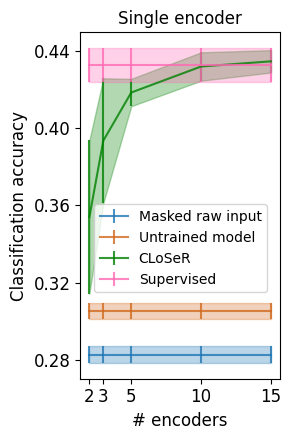

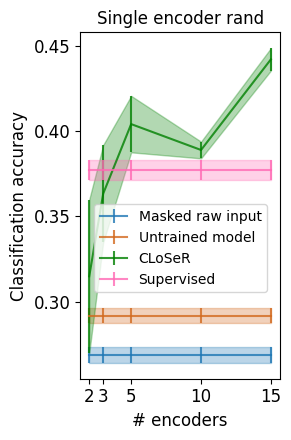

In [22]:
for rand in (False, True):
    fig, ax = plt.subplots(figsize=(3,height))

    plot_with_CI((img_results_N_rand if rand else img_results_N)[..., -1], NS, axis=-1, label=NamesAndColors.MASKED.value.name, c=NamesAndColors.MASKED.value.c)
    plot_with_CI((untrained_results_N_rand if rand else untrained_results_N)[..., -1], NS, axis=-1, label=NamesAndColors.UNTRAINED.value.name, c=NamesAndColors.UNTRAINED.value.c)
    plot_with_CI((unsupervised_results_N_rand if rand else unsupervised_results_N)[..., -1], NS, axis=-1, label=NamesAndColors.UNSUPERVISED.value.name, c=NamesAndColors.UNSUPERVISED.value.c)
    plot_with_CI((supervised_results_N_rand if rand else supervised_results_N)[..., -1], NS, axis=-1, label=NamesAndColors.SUPERVISED.value.name, c=NamesAndColors.SUPERVISED.value.c)

    plt.xlabel("# encoders", size=font_size)
    YLABEL_CLASS_F()
    ticksize(ax)
    set_num_ticks(ax)
    plt.xticks(NS, NS, size=font_size)
    plt.ylabel(ax.get_ylabel(), size=font_size)
    plt.title(SINGLE_ENCODER_TITLE + " rand"*rand, size=font_size)
    plt.tight_layout()
    plt.legend(loc=(.07, .25))
    savefig("d" + "_rand"*rand, 2)

# Figure 3

In [23]:
names_and_colors = [NamesAndColors.MASKED, NamesAndColors.UNTRAINED, NamesAndColors.UNSUPERVISED, NamesAndColors.SUPERVISED]
names_and_colors = [enum.value for enum in names_and_colors]

## Figure 3a

splitting randomly
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/3/a_mask_0.01_0.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/3/a_mask_0.025_0.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/3/a_mask_0.04_0.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/3/a_mask_0.05_0.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/3/a_mask_0.1_0.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/3/a_mask_0.15_0.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/3/a_mask_0.2_0.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/3/a_mask_0.25_0.svg
saved figure as figures/3/d_mask_0.01_0.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/3/d_mask_0.025_0.svg
using optimizer <class 'kera

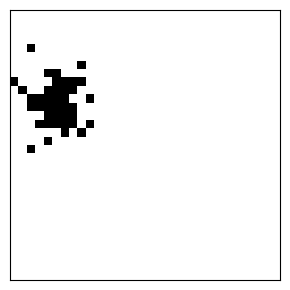

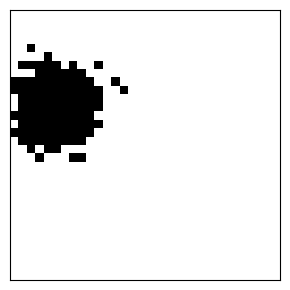

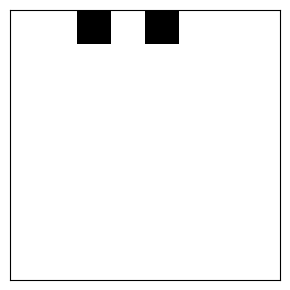

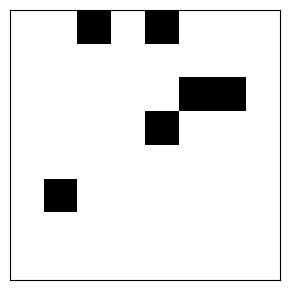

In [24]:
ds = Cifar10(split=True)
np.random.seed(10)
img_ind = np.random.randint(len(ds.get_x_train()))
img = ds.get_x_train()[img_ind]
# plot_imshow_masked(img)
# savefig(f"a_{img_ind}", 3)

for rand in (False, True):
    for q in QS_GAUS:
#         plot_imshow_masked(img, (model_format_closer_rand if rand else model_format_closer).format(d=q, seed=1))
#         savefig(f"a_{img_ind}_{q}_{0}" + "_rand"*rand, 3)
#         if q not in (chosen_q, chosen_q_rand): plt.close()
        
        plot_imshow_masked(img, (model_format_closer_rand if rand else model_format_closer).format(d=q, seed=1), plot_mask=True)
        savefig(f"{'d' if rand else 'a'}_mask_{q}_{0}", 3)
        if q not in (chosen_q, chosen_q_rand): plt.close()

## Figure 3b

In [25]:
from matplotlib import rcParams

def plot_single_encoder_along_q(rand=False, legend=False):
    fig, ax = plt.subplots(figsize=(3.75,3.5)) 
    plt.title(SINGLE_ENCODER_TITLE + " " + (LABEL_RAND_TITLE if rand else LABEL_GAUS_TITLE), size=font_size)
    ax.axhline(0.1, c=NamesAndColors.CHANCE.value.c, linestyle=':', label=NamesAndColors.CHANCE.value.name)
    for (name_and_color, name_format) in zip(names_and_colors[1:], 
                                             [model_format_untrained_rand, model_format_closer_rand, model_format_sup_rand] if rand else [model_format_untrained, model_format_closer, model_format_sup]):
        plot_along_q(name_format, module=Modules.VISION, seeds=SEEDS, args=[], 
                     qs=LESS_EXTENDED_QS if rand else QS_GAUS, ax=ax,
                     name=task_ind, fig=fig, legend=name_and_color.get_name(), 
                     c=name_and_color.get_c(), print_missing=True)

    Q_OVER_ACC_F(ax=ax, ticksize=8)
    plt.ylim(0, 0.7)
    plt.ylabel(ax.get_ylabel(), size=font_size)
    plt.xlabel(ax.get_xlabel(), size=font_size)

    ticksize(ax)
    set_num_ticks(ax, 4)
    less_extended_ticks()
    if legend:
        legend_linewidth(ax, 2, loc='lower right')

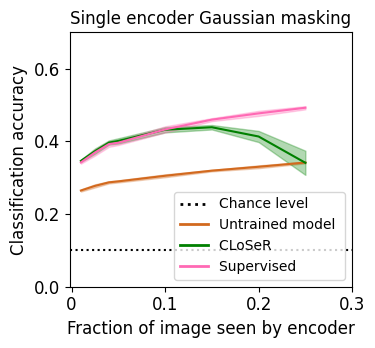

saved figure as figures/3/b.svg


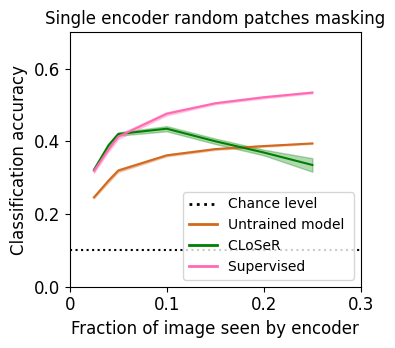

saved figure as figures/3/e.svg


In [26]:
for rand in (False, True):
    for legend in (True, False):
        plot_single_encoder_along_q(rand=rand, legend=legend)
        if legend:
            plt.show()
        else:
            savefig('e' if rand else "b", 3)
            plt.close()

## Figure 3b

In [27]:
def plot_ensemble_along_q(rand=False, legend=False):
    fig, ax = plt.subplots(figsize=(3.75,3.5))
    plt.title(ENSEMBLE_TITLE + " " + (LABEL_RAND_TITLE if rand else LABEL_GAUS_TITLE), size=font_size)
    ax.axhline(0.1, c=NamesAndColors.CHANCE.value.c, linestyle=':', label=NamesAndColors.CHANCE.value.name)
#     ax.axhline(full_img_baseline, label=NamesAndColors.MASKED.value.name, c=NamesAndColors.FULL_INPUT.value.get_c(), alpha=0.7)
    for i, (name_and_color, name_format) in enumerate(zip(names_and_colors[1:], 
                                                [model_format_untrained_rand, model_format_closer_rand, model_format_sup_rand] if rand else [model_format_untrained, model_format_closer, model_format_sup]
                                                         )):
        plot_along_q(name_format, module=Modules.VISION, seeds=SEEDS, args=[], qs=LESS_EXTENDED_QS if rand else QS_GAUS, ax=ax,
                           name=task_ens, fig=fig, legend=name_and_color.get_name(), 
                           c=name_and_color.get_c(), print_missing=True)
    Q_OVER_ACC_F(ax=ax, ticksize=8)
    plt.ylim(0, 0.7)
    plt.ylabel(ax.get_ylabel(), size=font_size)
    plt.xlabel(ax.get_xlabel(), size=font_size)
    ticksize(ax)
    set_num_ticks(ax, 4)
    less_extended_ticks()
    if legend:
        leg = legend_linewidth(ax, 2, loc='lower right')
    return ax

saved figure as figures/3/c.svg
saved figure as figures/3/legend.svg
saved figure as figures/3/f.svg
saved figure as figures/3/legend.svg


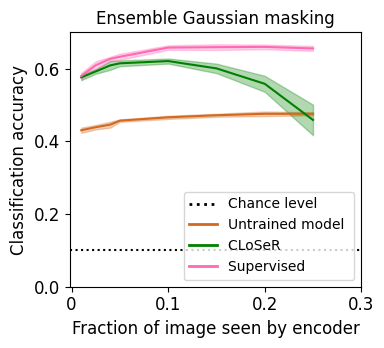

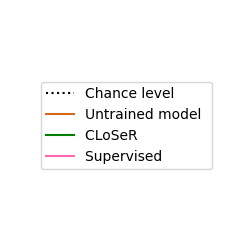

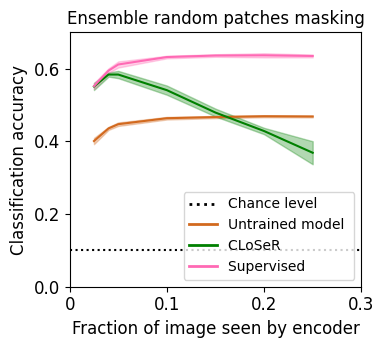

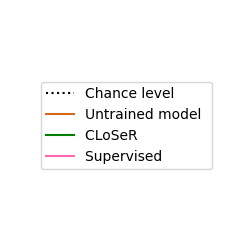

In [28]:
def export_legend(legend, expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    savefig("legend", 3)

for rand in (False, True):
    for legend in (False, True):
        ax = plot_ensemble_along_q(rand=rand, legend=legend)
        if legend:
            fig_leg = plt.figure(figsize=(3,3))
            ax_leg = fig_leg.add_subplot(111)
            ax_leg.legend(*ax.get_legend_handles_labels(), loc='center')
            ax_leg.axis('off')
            savefig("legend", 3)
        else:
            savefig('f' if rand else "c", 3)
            plt.close()

# Supplementary figure 1

## Supplementary figures 1a and 1b

saved figure as figures/s1/a.svg


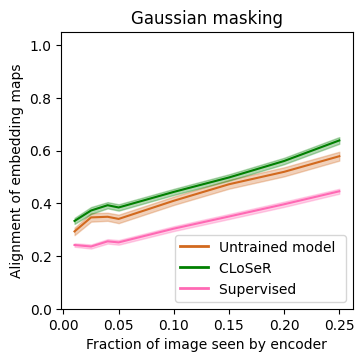

saved figure as figures/s1/b.svg


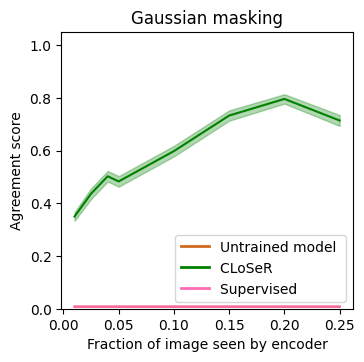

saved figure as figures/s1/c.svg


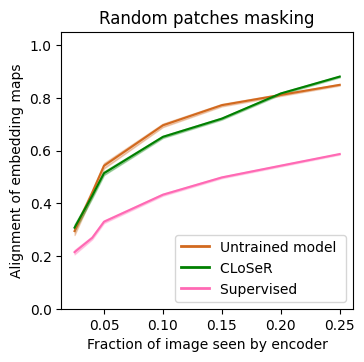

saved figure as figures/s1/d.svg


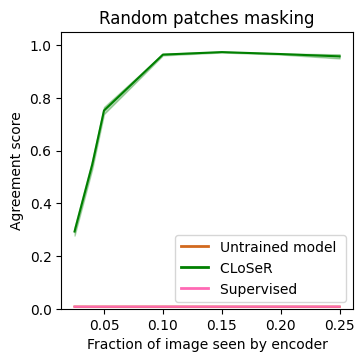

In [29]:
for rand in (False, True):
    for subfig, measure in enumerate([CrossPathMeasures.Correlation, CrossPathMeasures.Acc, ]):
        for leg in (False, True):
            fig, ax = plt.subplots(figsize=(3.75, 3.5))
            for nc, cur_model_name in zip((NamesAndColors.UNTRAINED.value, NamesAndColors.UNSUPERVISED.value, NamesAndColors.SUPERVISED.value),
                                          (model_format_untrained_rand, model_format_closer_rand, model_format_sup_rand) if rand else (model_format_untrained, model_format_closer, model_format_sup)):
                plot_along_q(cur_model_name,
                             module=Modules.VISION, 
                             seeds=SEEDS, 
                             args=[], 
                             qs=LESS_EXTENDED_QS if rand else QS_GAUS, 
                             name=measure.name, 
                             measure=True, 
                             fig=fig,
                             ax=ax,
                             legend=nc.name if leg else None, 
                             c=nc.color)

            Q_OVER_ACC_F(ticksize=8)
            plt.ylim(0, 1.05)
            plt.ylabel(measure.value)
            plt.title(("Random patches" if rand else 'Gaussian') + " masking")
            if leg:
                legend_linewidth(ax, loc='lower right')
                plt.show()
            else:
                savefig(("a" if subfig==0 else "b") if not rand else ("c" if subfig==0 else 'd'), "s1")
                plt.close()

# Supplementary figure 2

saved figure as figures/s2/a.svg
saved figure as figures/s2/b.svg


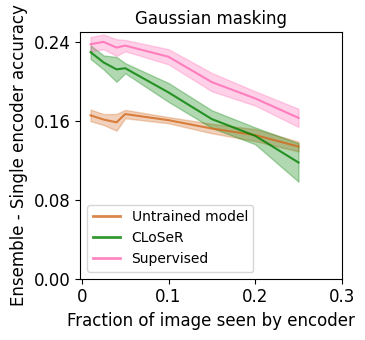

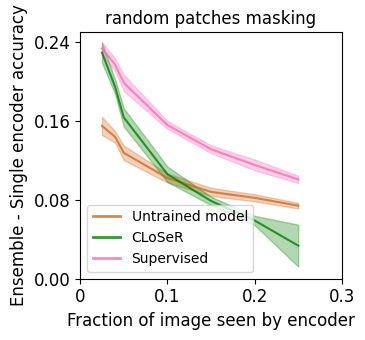

In [30]:
for rand in (False, True):
    qs = LESS_EXTENDED_QS if rand else QS_GAUS

    common_kwargs = dict(module=Modules.VISION, seeds=SEEDS, args=dict(d=qs), measure=False, print_missing=True)

    diff_arr_closer = np.diff(np.stack([gather_results_over_all_args((model_format_closer_rand if rand else model_format_closer).format(d='{d}', seed='{seed}'), 
                                                              **common_kwargs, name=task, ) 
                                 for task in [task_ind, task_ens]], axis=-1), axis=-1)[..., -1, 0]

    diff_arr_untrained = np.diff(np.stack([gather_results_over_all_args((model_format_untrained_rand if rand else model_format_untrained).format(d='{d}', seed='{seed}'), 
                                                              **common_kwargs, name=task, ) 
                                 for task in [task_ind, task_ens]], axis=-1), axis=-1)[..., -1, 0]

    diff_arr_supervised = np.diff(np.stack([gather_results_over_all_args((model_format_sup_rand if rand else model_format_sup).format(d='{d}', seed='{seed}'), 
                                                              **common_kwargs, name=task, ) 
                                 for task in [task_ind, task_ens]], axis=-1), axis=-1)[..., -1, 0]

    from utils.plot_utils import plot_with_CI
    fig, ax = plt.subplots(figsize=(3.75, 3.5))
    plot_with_CI(diff_arr_untrained, np.array(qs), axis=1, err=False,
                 c=NamesAndColors.UNTRAINED.value.c, label=NamesAndColors.UNTRAINED.value.name)
    plot_with_CI(diff_arr_closer, np.array(qs), axis=1, err=False, 
                 c=NamesAndColors.UNSUPERVISED.value.c, label=NamesAndColors.UNSUPERVISED.value.name)
    plot_with_CI(diff_arr_supervised, np.array(qs), axis=1, err=False, 
                 c=NamesAndColors.SUPERVISED.value.c, label=NamesAndColors.SUPERVISED.value.name)
    XLABEL_FRAC_F()
    plt.title(LABEL_RAND_TITLE if rand else LABEL_GAUS_TITLE)
    plt.ylabel(f"{EVAL_ENS_LIN_NAME} - {EVAL_IND_LIN_NAME} accuracy")
    legend_linewidth(ax, loc='lower left')
    plt.ylim(0, 0.25)
    less_extended_ticks()
    ticksize(ax)
    set_num_ticks(ax, 4)
    plt.ylabel(ax.get_ylabel(), size=font_size)
    plt.xlabel(ax.get_xlabel(), size=font_size)
    plt.tight_layout()
    savefig("a" if not rand else "b", "s2")

# Figure 4

## Figure 4a

In [31]:
ds = Cifar10(split=True)
img = ds.get_x_train()[0]

splitting randomly


using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/4/a_mask_0_std=2.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/4/a_mask_0_std=3.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/4/a_mask_0_std=5.svg


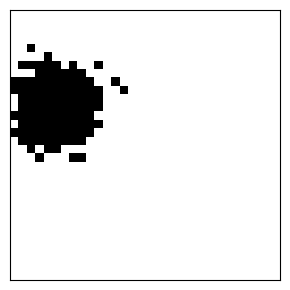

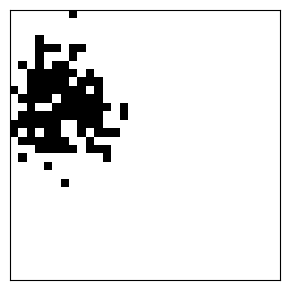

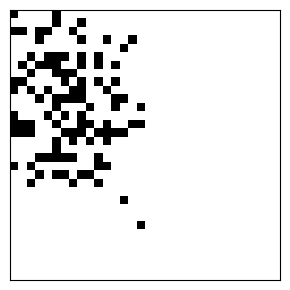

In [32]:
for std in (2,3,5):
    cur_format = model_format_closer
    if std != 2:
        cur_format = cur_format.replace("gaus2", f"gaus{std}")
        cur_format = cur_format.replace("actual_", "").replace("actual", "")
    plot_imshow_masked(img, cur_format.format(d=0.1, seed=1), plot_mask=True, cmap='binary') 
    savefig(f"a_mask_{0}_{std=}", 4)

using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/4/a_mask_0_patch=1.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/4/a_mask_0_patch=2.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/4/a_mask_0_patch=4.svg


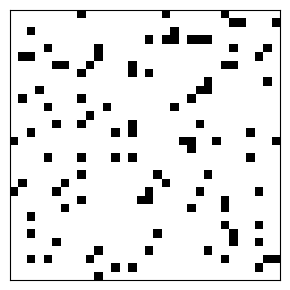

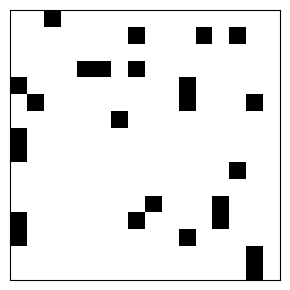

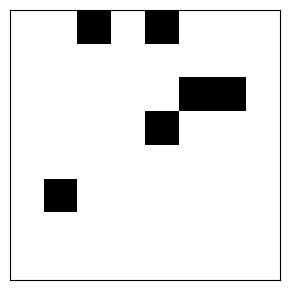

In [33]:
model_format_1x1 = "fc_nopatch_rgb_10_fixed_d{d}_seed{seed}_1024_512_256_out256_encperpath_mse_log_noreg"
model_format_2x2 = "fc_nopatchenc_10_fixed_patch2_d{d}_seed{seed}_1024_512_256_out256_encperpath_mse_log_noreg"
model_format_4x4 = "fc_nopatchenc_10_fixed_d{d}_seed{seed}_1024_512_256_out256_encperpath_actualmse_log_noreg"
for patch, cur_model_format in zip([1,2,4], [model_format_1x1, model_format_2x2, model_format_4x4]):
    plot_imshow_masked(img, cur_model_format.format(d=0.1, seed=1), plot_mask=True, cmap='binary')
    savefig(f"a_mask_{0}_{patch=}", 4)

## Figure 4

/tmp/ipykernel_3470755/4049258237.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Greens')
/home/projects/schneidmann/royu/thesis/unsup_neur/utils/plot_utils.py:183: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (plt if ax is None else ax).scatter([x],mean,marker='o',c=c)
/tmp/ipykernel_3470755/4049258237.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``py

saved figure as figures/4/b.svg


/tmp/ipykernel_3470755/4049258237.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Greens')
/home/projects/schneidmann/royu/thesis/unsup_neur/utils/plot_utils.py:183: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (plt if ax is None else ax).scatter([x],mean,marker='o',c=c)
/tmp/ipykernel_3470755/4049258237.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``py

saved figure as figures/4/b.svg


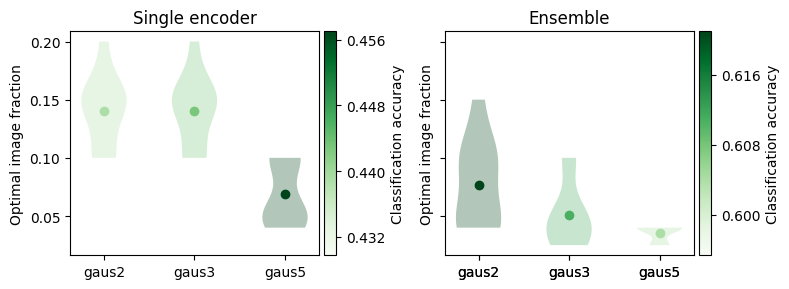

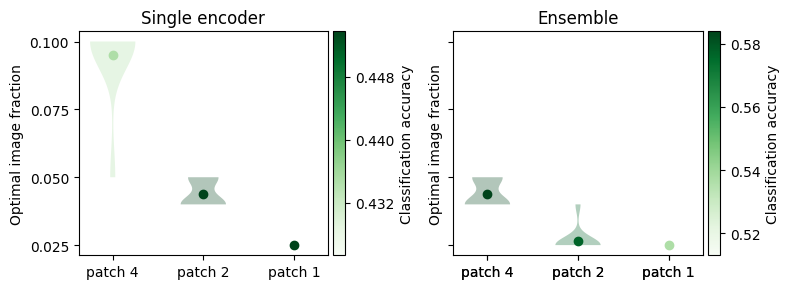

In [34]:
from utils.plot_utils import dct_to_multiviolin
for which in (0, 1):
    fig,axs=plt.subplots(1,2,sharey=True, figsize=(8, 3))
    min_c,max_c=None,None
    xs,ys,cs=[],[],[]
    xs_ens,ys_ens,cs_ens=[],[],[]
    ticks=[]
    for i, (ax, task, title, (xs_cur, ys_cur, cs_cur)) in enumerate(zip(axs, (task_ind, task_ens), (SINGLE_ENCODER_TITLE, ENSEMBLE_TITLE), ([xs,ys,cs], [xs_ens,ys_ens,cs_ens]))):
        ax=plt.subplot(1,2,i+1)
        if not which:
            for j,std in enumerate([2,3,5]):
                cur_format = model_format_closer.replace("gaus2", f"gaus{std}")
                if cur_format!=model_format_closer:
                    cur_format = cur_format.replace("actual_", "").replace("actual", "")
                arr=gather_results_over_all_args(cur_format, args=dict(d=QS_GAUS), module=Modules.VISION, name=task, seeds=SEEDS)[...,-1]
                argmax=np.nanargmax(arr,axis=0)
                ticks.append(f'gaus{std}')
                xs_cur.append(j)
                ys_cur.append(QS_GAUS[argmax])
                cs_cur.append(np.nanmax(np.nanmean(arr,axis=-1)))        
        else:
            for j,(p,cur_format) in enumerate(zip([1,2,4][::-1], [model_format_1x1,model_format_2x2,model_format_4x4][::-1])):
                arr=gather_results_over_all_args(cur_format, args=dict(d=LESS_EXTENDED_QS), module=Modules.VISION, name=task, seeds=SEEDS)[...,-1]
                argmax=np.nanargmax(arr,axis=0)
                ticks.append(f'patch {p}')
                xs_cur.append(4+j)
                ys_cur.append(np.array(LESS_EXTENDED_QS)[argmax])
                cs_cur.append(np.nanmax(np.nanmean(arr,axis=-1)))        
        cmap='Greens'
        min_c,max_c=np.nanmin(cs_cur),np.nanmax(cs_cur)
        norm = plt.Normalize(vmin=min_c-0.5*(max_c-min_c), vmax=max_c)

        cmap=plt.cm.get_cmap('Greens')
        dct_to_multiviolin({t:y for t, y in zip(ticks,ys_cur)}, 
                           c={t: cmap(norm(c))
                              for t,c in zip(ticks, cs_cur)}, 
                           xs=xs_cur, ax=ax, plot_CI=False)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = colorbar(sm, ax=ax)
        cbar.set_label("Classification accuracy")
        from matplotlib import ticker
        cbar.locator = ticker.MaxNLocator(nbins=4)
        cbar.update_ticks()
        plt.xticks(xs+xs_ens, ticks)
        set_num_ticks(ax,4)
        plt.ylabel("Optimal image fraction") 
        plt.title(title)
        plt.tight_layout()
    savefig(('a','b')[i], 4)

# Supplementary figure 3

## Supplementary Figure 3b-c

saved figure as figures/s3/b.svg
saved figure as figures/s3/c.svg


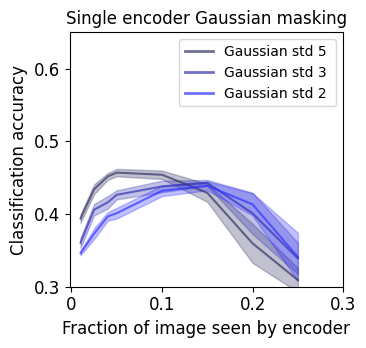

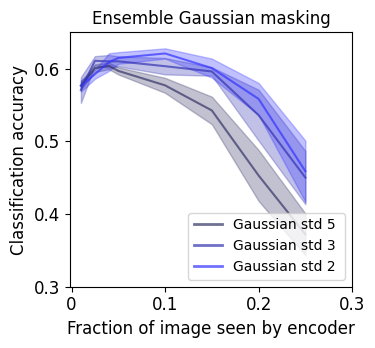

In [35]:
for subfig, task, title in zip(('b', 'c'), (task_ind, task_ens), (SINGLE_ENCODER_TITLE, ENSEMBLE_TITLE)):

    fig, ax = plt.subplots(figsize=(3.75,3.5)) 
    plt.title(title + " " + LABEL_GAUS_TITLE, size=font_size)
    # ax.axhline(0.1, c=NamesAndColors.CHANCE.value.c, linestyle=':', label=NamesAndColors.CHANCE.value.name)
    for i,std in enumerate([5,3,2]):
        cur_format = model_format_closer.replace("gaus2", f"gaus{std}")
        if cur_format!=model_format_closer:
            cur_format = cur_format.replace("actual_", "").replace("actual", "")
        plot_along_q(cur_format, module=Modules.VISION, seeds=SEEDS, args=[], 
                     qs=QS_GAUS, ax=ax,
                     name=task, fig=fig, legend=f"Gaussian std {std}", 
                     c=[0.2, 0.2, 0.4+0.3*i, 0.7], print_missing=True)

    Q_OVER_ACC_F(ax=ax, ticksize=8)
    plt.ylabel(ax.get_ylabel(), size=font_size)
    plt.xlabel(ax.get_xlabel(), size=font_size)

    plt.ylim(0.3, 0.65)
    ticksize(ax)
    set_num_ticks(ax, 4)
    
    less_extended_ticks()
    legend_linewidth(ax, 2, loc='upper right' if task==task_ind else 'lower right')
    savefig(subfig, "s3")    

## Supplementary Figure 3d-e

saved figure as figures/s3/d.svg
saved figure as figures/s3/e.svg


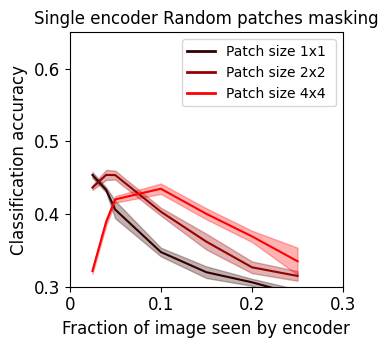

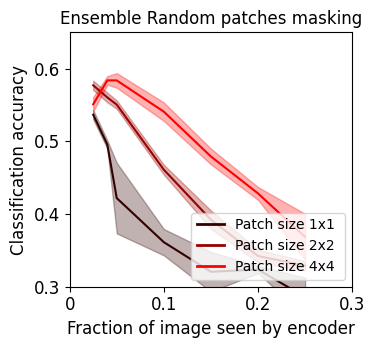

In [36]:
for subfig, task, title in zip(('d', 'e'), (task_ind, task_ens), (SINGLE_ENCODER_TITLE, ENSEMBLE_TITLE)):

    fig, ax = plt.subplots(figsize=(3.75,3.5)) 
    plt.title(title + " " + LABEL_RAND, size=font_size)
    
    shared_kwargs = dict(module=Modules.VISION, seeds=SEEDS, args=[], 
                         qs=LESS_EXTENDED_QS, ax=ax,
                         name=task, fig=fig, print_missing=True)
    
    plot_along_q(model_format_1x1, legend=f"Patch size 1x1", c=[0.2, 0, 0], **shared_kwargs)
    plot_along_q(model_format_2x2, legend=f"Patch size 2x2", c=[0.6, 0, 0], **shared_kwargs)
    plot_along_q(model_format_4x4, legend=f"Patch size 4x4",  c=[1, 0, 0], **shared_kwargs)

    Q_OVER_ACC_F(ax=ax, ticksize=8)
    plt.ylabel(ax.get_ylabel(), size=font_size)
    plt.xlabel(ax.get_xlabel(), size=font_size)
    plt.ylim(0.3, 0.65)
    ticksize(ax)
    set_num_ticks(ax, 4)
    less_extended_ticks()
    legend_linewidth(ax, 2, loc='upper right' if task==task_ind else 'lower right')
    savefig(subfig, 's3')    

# Figure 5

In [37]:
from vision.model.losses import CLoSeRLoss, CirculantGraphLoss, NumEdgesGraphLoss, StarGraphLoss

class GraphFeatures:
    def __init__(self, graph, name, color, name_format='', pos=None):
        self.graph = graph
        self.name = name
        self.color = color
        self.c = color
        self.noint_c, self.int_c = color
        self.name_format = name_format
        self.pos = pos
        self.density = self.graph.get_graph().astype(bool)[~np.eye(self.graph.get_graph().shape[0]).astype(bool)].mean()
        self.intra_mask = self.graph.get_graph().astype(bool)
        self.extra_mask = ~self.graph.get_graph().astype(bool) & ~np.eye(self.graph.get_graph().shape[0]).astype(bool)
    
    def plot(self, title=True, text_size=10, cbar=False, ax=None, **kwargs):
        if ax is None:
            fig, ax = plt.subplot(111)
        self.graph.plot_pull(interaction_c=self.int_c, nointeraction_c=self.noint_c, text_size=text_size, cbar=cbar, ax=ax, **kwargs)
        ax.set_xticks([])
        ax.set_yticks([])
        
    def illustrate(self, multicolor=False, fontsize=10, ax=None, node_size=500, arrowsize=25, width=3,):
        import networkx as nx
        
        G = nx.from_numpy_array(self.graph.get_graph().T, create_using=nx.DiGraph)
        node_colors = self.c # Default to gray if color is missing
        pos = nx.circular_layout(G) if self.pos is None else self.pos
        if ax is None: plt.figure()
        nx.draw(G, pos, with_labels=False, node_color=node_colors[1], edge_color=node_colors[1], 
                node_size=node_size, width=width, font_size=fontsize, arrowstyle='->', arrowsize=arrowsize, ax=ax)
        (ax if ax is not None else plt).axis("equal")

In [38]:
NUMEDGES = np.arange(10, 81, 10)
circular_n = lambda n, shift=0, phase=0: {i+shift: np.array([np.cos(i/n*2*np.pi + phase), np.sin(i/n*2*np.pi + phase)]) for i in range(n)}
pos_star = circular_n(N-1, 1)
pos_star[0] = np.zeros(2)

In [39]:
from enum import Enum
np.random.seed(2)    
class Graph(Enum):
    FULLY_CONNECTED = GraphFeatures(CLoSeRLoss(N), "Fully-connected", [[0]*4, [0, 0.3, 0, 0.6]])
    NUMEDGES = GraphFeatures(NumEdgesGraphLoss(N, num_edges_pull=20), r"$G_N^k$", [[0]*4, [0, 0.5, 0.7, 0.8]], "numedges{numedges}")    
    STAR = GraphFeatures(StarGraphLoss(N, 1), "Star structure", [[0]*4, [0.9, 0.1, 0, 0.7]], "star", pos=pos_star)
    BIRING = GraphFeatures(CirculantGraphLoss(N, 1, symmetric=True), "Bidirectional ring", [[0]*4, [0.5, 0, 0.5, 0.7]], "biring")
    FORRING = GraphFeatures(CirculantGraphLoss(N, 2), "Directional ring", [[0]*4, [0.9, 0.5, 0, 0.7]], "direcring")

## Figure 5a

/home/projects/schneidmann/royu/.local/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


saved figure as figures/5/a.svg


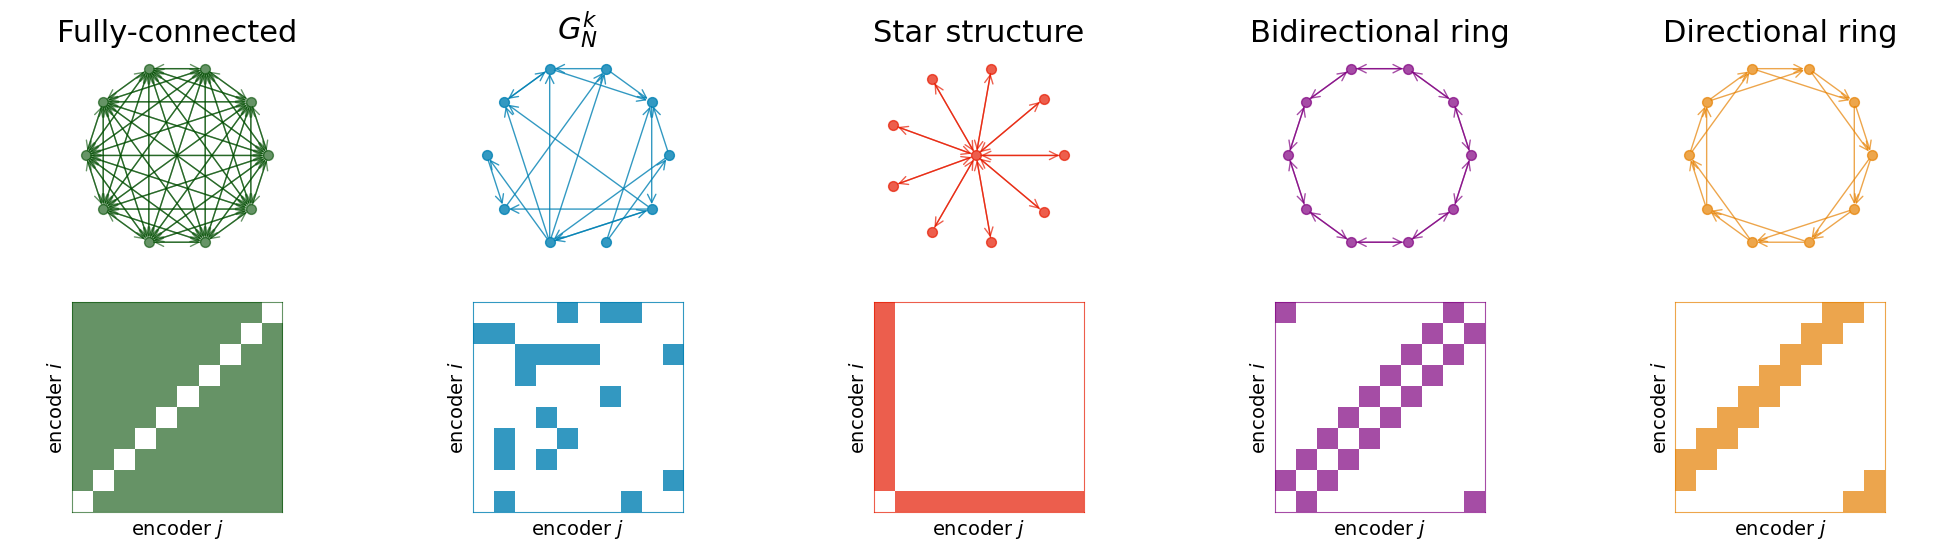

In [40]:
fig, axs = plt.subplots(2, len(Graph), figsize=(len(Graph)*5, 6))
for i, g in enumerate(Graph):
    ax = plt.subplot(2, len(Graph), i+1)
    plt.title(g.value.name, fontsize=22)
    g.value.illustrate(ax=ax, node_size=50, arrowsize=15, width=1)

    ax = plt.subplot(2, len(Graph), len(Graph) + i + 1)
    g.value.plot(ticks=True, cbar=False, labels=True, text_size=14, figsize=(2,2), ax=ax)

savefig("a", 5)

In [41]:
# Plot individuals (and edit afterwards using drawio)
for i, g in enumerate(Graph):
    g.value.illustrate()
    savefig(f"{g.value.name}", "5/a_graphs")
    plt.close()
    
    g.value.plot(ticks=True, cbar=False, labels=True, text_size=14, figsize=(2,2), ax=ax)
    savefig(f"{g.value.name}", "5/a_mats")
    plt.close()

saved figure as figures/5/a_graphs/Fully-connected.svg
saved figure as figures/5/a_mats/Fully-connected.svg
saved figure as figures/5/a_graphs/$G_N^k$.svg
saved figure as figures/5/a_mats/$G_N^k$.svg
saved figure as figures/5/a_graphs/Star structure.svg
saved figure as figures/5/a_mats/Star structure.svg
saved figure as figures/5/a_graphs/Bidirectional ring.svg
saved figure as figures/5/a_mats/Bidirectional ring.svg
saved figure as figures/5/a_graphs/Directional ring.svg
saved figure as figures/5/a_mats/Directional ring.svg


## Figure 5b and supplementary figure 4

In [42]:
font_size_graphs = 12
plot_with_CI_kwargs = dict(capsize=2, markersize=7, marker='o', fill_between=False,)
densities = np.array([0] + list(NUMEDGES) + [90]) / 90
XLABEL_INTER_F = lambda ax=None, **kwargs: (ax.set_xlabel if ax else plt.xlabel)("Interaction density", **kwargs)

focus_density = Graph.FORRING.value.density

Single encoder Gaussian masking
	Direcring vs. G^k_N: ∗∗ 4.3e-03
	Biring vs. G^k_N: ∗∗ 8.9e-03
saved figure as figures/5/b.svg


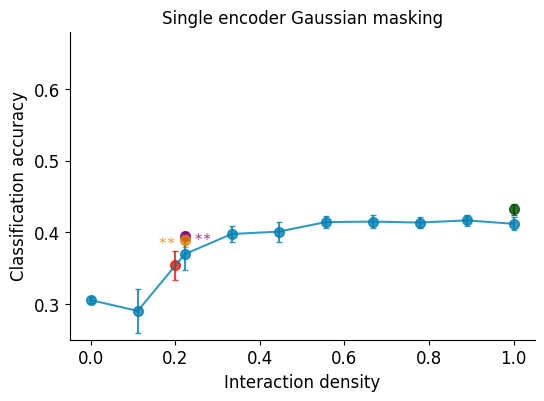

Ensemble Gaussian masking
	Direcring vs. G^k_N: ∗ 4.4e-02
	Biring vs. G^k_N: ∗∗ 4.8e-03
saved figure as figures/5/c.svg


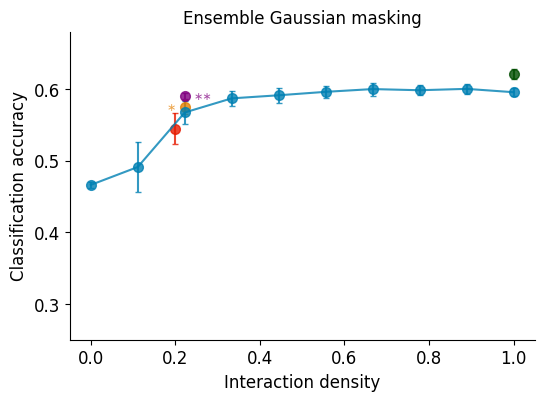

saved figure as figures/s4/a.svg


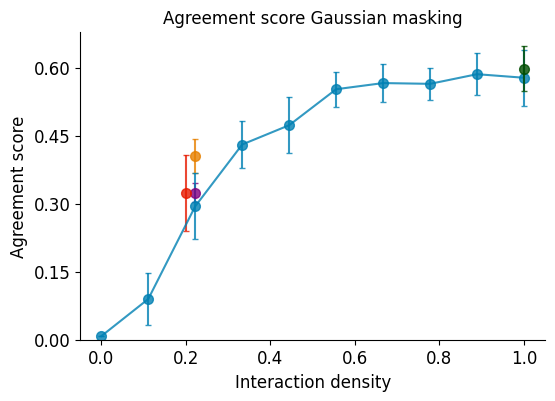

saved figure as figures/s4/b.svg


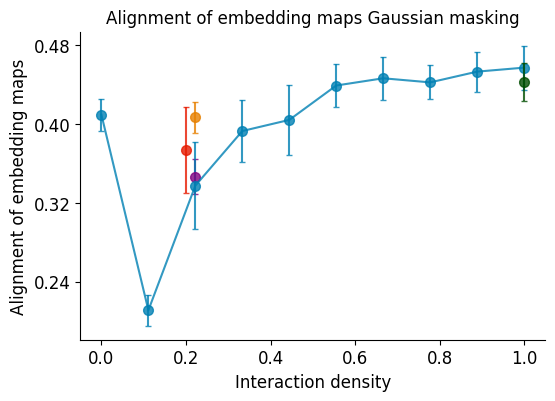

Single encoder random patches masking
	Direcring vs. G^k_N: ∗ 1.4e-02
	Biring vs. G^k_N:  1.1e-01
saved figure as figures/5/b_rand.svg


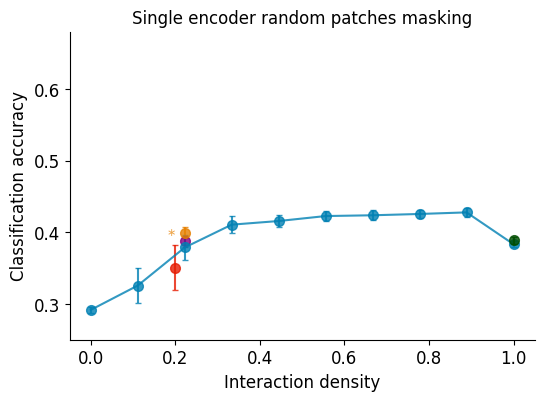

Ensemble random patches masking
	Direcring vs. G^k_N:  1.8e-01
	Biring vs. G^k_N:  1.4e-01
saved figure as figures/5/c_rand.svg


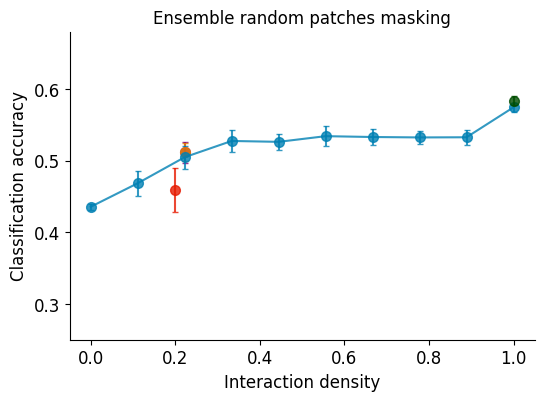

saved figure as figures/s4/a_rand.svg


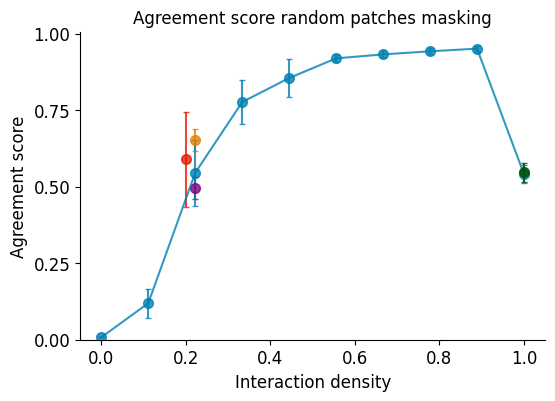

saved figure as figures/s4/b_rand.svg


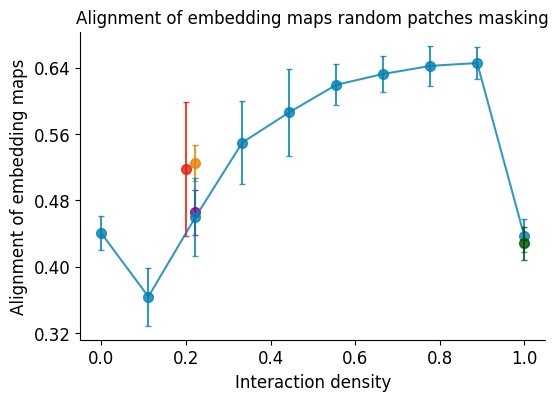

In [43]:
for rand in (False, True):
    if rand:
        basic_graph_format = "fc_nopatchenc_10_fixed_d{d}_seed{{seed}}_1024_512_256_out256_encperpath_actualmse_log_noreg_{name}_othersg"
    else:
        basic_graph_format = "fc_nopatch_actual_gaus2_10_fixed_d{d}_seed{{seed}}_1024_512_256_out256_encperpath_actualmse_log_noreg_{name}_othersg"
    
    for task_n, (task_name, task, measure, subplot, figure) in enumerate(((EVAL_IND_LIN_NAME, EVAL_IND_LIN, False, 'b', 5), 
                                                            (EVAL_ENS_LIN_NAME, EVAL_ENS_LIN, False, 'c', 5),
                                                            (CrossPathMeasures.Acc.value, CrossPathMeasures.Acc.name, True, 'a', 's4'),
                                                            (CrossPathMeasures.Correlation.value, CrossPathMeasures.Correlation.name, True, 'b', 's4'),
                                                           )):
        q = chosen_q_rand if rand else chosen_q
        common_kwargs = dict(args={}, module=Modules.VISION, seeds=SEEDS, name=task, print_missing=True, measure=measure)

        fig, ax = plt.subplots(figsize=(6,4))    
        plt.title(task_name + " " + (LABEL_RAND_TITLE if rand else LABEL_GAUS_TITLE), fontsize=font_size_graphs)

        dct = {}
        cs = {}

        process_metric = lambda arr: arr[..., ~np.eye(N).astype(bool)].mean(axis=-1) if measure else arr[..., -1]


        for g in [Graph.BIRING.value, Graph.FORRING.value]:
            dct[g.name] = process_metric(gather_results_over_all_args(basic_graph_format.format(name=g.name_format, d=q), **common_kwargs))
            cs[g.name] = g.int_c

        for k in dct:
            plot_with_CI(dct[k][None], np.array([focus_density]), axis=-1, c=cs[k], **plot_with_CI_kwargs)

        fc_graph = process_metric(gather_results_over_all_args((model_format_closer_rand if rand else model_format_closer).format(d=q, seed="{seed}"), **common_kwargs))
        plot_with_CI(fc_graph[None], densities[-1:], axis=-1, c=Graph.FULLY_CONNECTED.value.int_c, zorder=10, **plot_with_CI_kwargs)


        star_res = process_metric(gather_results_over_all_args(basic_graph_format.format(name=Graph.STAR.value.name_format, d=q), **common_kwargs))
        plot_with_CI(star_res[None], np.array([Graph.STAR.value.density]), axis=-1, c=Graph.STAR.value.int_c, **plot_with_CI_kwargs)


        numedges_res = np.full((2 + NUMEDGES.size, SEEDS.size), np.nan)
        numedges_res[0] = process_metric(gather_results_over_all_args((model_format_untrained_rand if rand else model_format_untrained).format(d=q, seed="{seed}"), **common_kwargs))
        numedges_res[-1] = process_metric(gather_results_over_all_args((model_format_closer_rand if rand else model_format_closer).format(d=q, seed="{seed}") + "_othersg", **common_kwargs))
        for i, numedges in enumerate(NUMEDGES):
            numedges_res[1+i] = process_metric(gather_results_over_all_args(basic_graph_format.format(name=Graph.NUMEDGES.value.name_format.format(numedges=numedges), d=q), **common_kwargs))
        plot_with_CI(numedges_res, densities, axis=-1, c=Graph.NUMEDGES.value.int_c, **plot_with_CI_kwargs)
        dct_same_dens = {
            Graph.FORRING.value.name: dct[Graph.FORRING.value.name], 
            Graph.NUMEDGES.value.name: numedges_res[np.where(densities == focus_density)[0][0]],
            Graph.BIRING.value.name: dct[Graph.BIRING.value.name]
        }

        # significance plot
        from utils.plot_utils import pvalue_to_str
        p_direc = paired_t_test(dct_same_dens[Graph.FORRING.value.name], dct_same_dens[Graph.NUMEDGES.value.name], alternative='greater')
        p_bi = paired_t_test(dct_same_dens[Graph.BIRING.value.name], dct_same_dens[Graph.NUMEDGES.value.name], alternative='greater')
        if not measure:
            print(task_name, LABEL_RAND_TITLE if rand else LABEL_GAUS_TITLE)
            print(f"\tDirecring vs. G^k_N: {pvalue_to_str(p_direc)} {p_direc:.1e}")
            print(f"\tBiring vs. G^k_N: {pvalue_to_str(p_bi)} {p_bi:.1e}")
        
        if not measure: plt.text(focus_density-0.02, np.nanmean(dct_same_dens[Graph.FORRING.value.name]), 
                                 pvalue_to_str(p_direc), ha='right', va='center', size=8, c=Graph.FORRING.value.int_c)
        if not measure: plt.text(focus_density+0.02, np.nanmean(dct_same_dens[Graph.BIRING.value.name]), 
                                 pvalue_to_str(p_bi), ha='left', va='center', size=8, c=Graph.BIRING.value.int_c)


        # ticks and axes
        XLABEL_INTER_F(fontsize=font_size_graphs)
        if measure:
            plt.ylabel(task_name, fontsize=font_size_graphs)
        else:
            YLABEL_CLASS_F(fontsize=font_size_graphs)
        if not measure:
            plt.ylim(0.25, 0.68)
        else:
            if plt.ylim()[0] < 0:
                plt.ylim(0)
        
        ticksize(ax)
        set_num_ticks(ax, 5)

        plt.xticks(np.linspace(0, 1, 6), size=font_size_graphs)    
        remove_spines(ax, top_right=True)
        savefig(subplot + "_rand"*rand, figure)
        plt.show()

# Supplementary figure 4

see figure 5b

# Figure 6

In [44]:
vit_format = "vit_lite_2_4_paths_10_d{d}_seed{seed}_encperpath_patchperpath" 
vit_format_contig = "vit_lite_2_4_paths_10_d{d}_seed{seed}_contig_encperpath_patchperpath" 
vit_unsup_end = "_noreg"
vit_untrained_end = "_untrained"
vit_supervised_end = "_pathsup"

## Figure 6a

splitting randomly
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/6/a_mask_0.2_4_contig.svg
using optimizer <class 'keras.optimizer_v2.nadam.Nadam'>
saved figure as figures/6/a_mask_0.2_4.svg


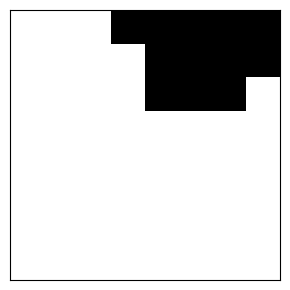

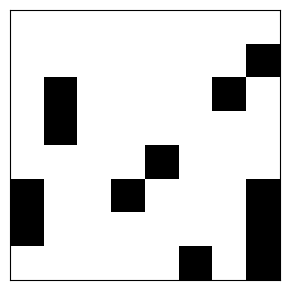

In [45]:
ds = Cifar10(split=True)
np.random.seed(1)
img_ind = np.random.randint(len(ds.get_x_train()))
img = ds.get_x_train()[img_ind]
p = 4
for rand in (False, True):
    q = 0.2
    plot_imshow_masked(img, (vit_format if rand else vit_format_contig).format(d=q, seed=1) + vit_unsup_end, p, plot_mask=True)
    savefig(f"a_mask_{q}_{p}" + "_contig"*(not rand), 6)

## Figure 6c-d and 6f-g

saved figure as figures/6/f.svg
saved figure as figures/6/g.svg
saved figure as figures/6/c.svg
saved figure as figures/6/d.svg


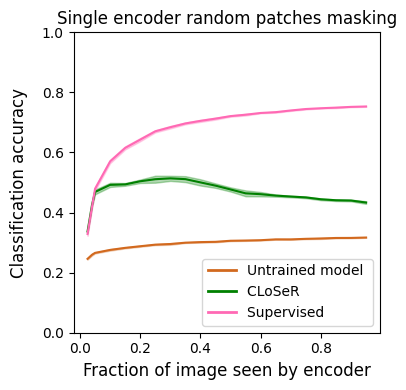

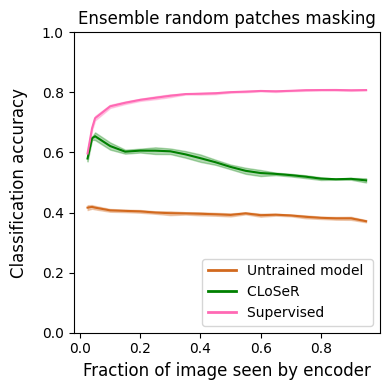

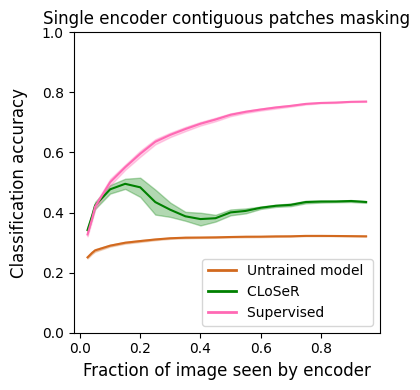

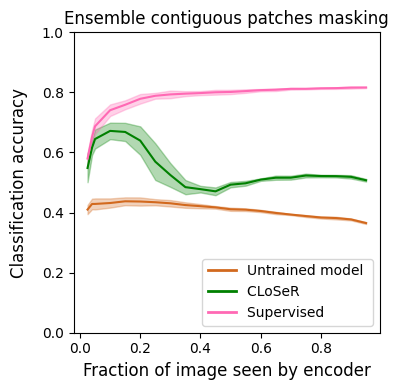

In [46]:
for i, vit_cur_format in enumerate((vit_format, vit_format_contig)):
    for subfig, t, task_name in zip(("c", "d") if i else ("f", "g"), (task_ind, task_ens), (EVAL_IND_LIN_NAME,EVAL_ENS_LIN_NAME)):
        fig, ax = plt.subplots(figsize=(4,4))
        for name_and_color, end in zip([NamesAndColors.UNTRAINED, NamesAndColors.UNSUPERVISED, NamesAndColors.SUPERVISED, ], 
                                            [vit_untrained_end, vit_unsup_end, vit_supervised_end]):
            plot_along_q(vit_cur_format + end, module=Modules.VISION, seeds=SEEDS, args=[], ax=ax,
                         suptitle=False, qs=EXTENDED_QS, name=t, fig=fig, 
                         legend=name_and_color.value.name, c=name_and_color.value.c, print_missing=True)

        Q_OVER_ACC_F()
        plt.title(task_name + " " + (LABEL_RAND_TITLE if not i else "contiguous patches masking"), size=font_size)
        plt.subplots_adjust(top=0.92)
        plt.ylabel(ax.get_ylabel(), size=font_size, labelpad=10)
        plt.xlabel(ax.get_xlabel(), size=font_size)
        # XTICKS_FRAC_F()
        plt.tight_layout()
        legend_linewidth(ax, loc='lower right')
        savefig(subfig, 6)

# Figure 7

# Figure 8

In [47]:
from neuronal.utils.data import Session, SessionDataGenerator, SplitScheme
from neuronal.utils.consts import SESSIONS, USED_AREAS

In [48]:
data_kwargs = Modules.NEURONAL.load_json("paths_10_seed1_ses12_LP_VISrl_CA1_VISam_PO_LGd_VISp_SUB_Eth_SGN_mod_frames2_bps1_MLP", 
                                         config=True)['data_kwargs']

In [49]:
ses = SessionDataGenerator(Modules.NEURONAL, **data_kwargs)

In [50]:
cmap='Greens'

saved figure as figures/8/full_mat.svg


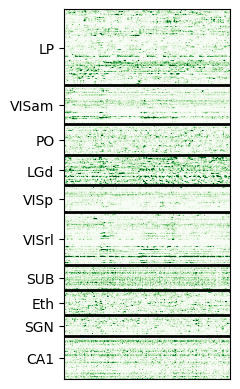

In [51]:
np.random.seed(15)
areas = np.array(sorted(ses.num_units.keys()))
num_units = np.array([ses.num_units[area] for area in areas])
keys_order = np.array(np.argsort(num_units))[::-1][[0,3,4,5,6,1,7,8,9,2]]
T = 300
arr = np.concatenate([ses.spikes['natural_movie_one'][area][3][:, :T] for area in areas[keys_order]], axis=0)
plt.imshow(arr, cmap=cmap, vmax=2, vmin=0)
plt.xticks([])
plt.yticks([])

plt.yticks(np.array([0] + list(np.cumsum(num_units[keys_order]))[:-1]) + num_units[keys_order]/2, areas[keys_order])
for n in np.cumsum(num_units[keys_order])[:-1]:
    plt.axhline(n-0.5, c='k', linewidth=2)
    
savefig(f"full_mat", 8)

saved figure as figures/8/single_bin.svg


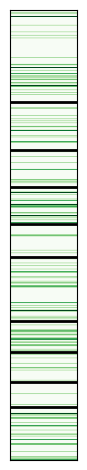

In [52]:
plt.imshow(np.tile(arr[:, 160:161], [1, 100]), cmap=cmap, vmin=0, vmax=2)
plt.xticks([])
plt.yticks([])
for n in np.cumsum(num_units[keys_order])[:-1]:
    plt.axhline(n-0.5, c='k', linewidth=2)
plt.tight_layout()
savefig(f"single_bin", 8)

saved figure as figures/8/mask0.svg
saved figure as figures/8/mask5.svg
saved figure as figures/8/mask9.svg


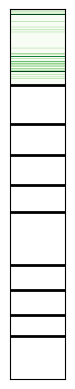

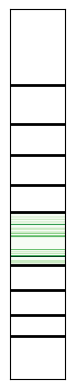

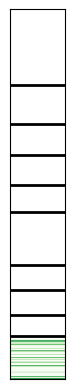

In [53]:
total = np.array([0] + list(np.cumsum(num_units[keys_order])))
for i in (0, len(areas)//2, len(areas)-1):
    plt.figure()
    inds = np.arange(total[-1])
    mask = (inds < total[i+1]) & (inds >= total[i])
    
    plt.imshow(np.tile(np.where(mask[..., None], arr[:, 160:161], np.nan), [1, 100]), cmap=cmap, vmin=0, vmax=2)
    plt.xticks([])
    plt.yticks([])
    for n in np.cumsum(num_units[keys_order])[:-1]:
        plt.axhline(n-0.5, c='k', linewidth=2)
    savefig(f"mask{i}", 8)    

# Figure 9

In [54]:
NEUR_SEEDS = np.arange(1,31)

In [55]:
ses_and_areas = [
    "12_LP_VISrl_CA1_VISam_PO_LGd_VISp_SUB_Eth_SGN", 
    "15_VISam_VISp_VISpm_ProS_VISrl_CA1_LGd_VISal_VISl_MGv",
    "17_LP_CA1_VISp_PO_VISam_VISl_VISal_SGN_SUB_VISrl",
    "18_CA1_VISp_VISam_LP_VISli_VISal_ProS_VISrl_LGd_MB", 
]
neur_model_format = "paths_10_seed{{seed}}_ses{ses}_mod_frames2_bps1_MLP"
LPL_ending = "_LPL_reg_5e-6"
TCLoSeR_ending = "_var_cov_crosscont2_reg_5e-6"
untrained_ending = ""

In [56]:
from enum import Enum
crosscont_w = 2

class NeuNameAndColors(Enum):
    UNTRAINED = NameAndColor(NamesAndColors.UNTRAINED.value.name, color=NamesAndColors.UNTRAINED.value.c, 
                             ending=untrained_ending, inp=False, pred=False)
    MASKED = NameAndColor(NamesAndColors.MASKED.value.name, color=NamesAndColors.MASKED.value.c, 
                          ending=untrained_ending, inp=True, pred=False)
    LPL = NameAndColor("LPL", c='brown', ending=LPL_ending, inp=False, pred=False)
    TCLoSeR = NameAndColor("T" + NamesAndColors.UNSUPERVISED.value.name, 
                        c=NamesAndColors.UNSUPERVISED.value.c, ending=TCLoSeR_ending, inp=False, pred=False)

In [57]:
from neuronal.utils.data import Labels as NeurLabels

input_txt = 'input'
task_ens_neur = 'linear'

lbl_neur = NeurLabels.STIMULUS.value.name
full_name_task_neur_ind = '_'.join([lbl_neur, task_ind])
full_name_task_neur_ens = '_'.join([lbl_neur, task_ens_neur])
full_name_task_neur_ind_inp = '_'.join([lbl_neur, input_txt, task_ind])
full_name_task_neur_ens_inp = '_'.join([lbl_neur, input_txt, task_ens_neur])

In [58]:
class Metric:
    def __init__(self, measure, task_name, task, task_inp):
        self.measure = measure
        self.task_name = task_name
        self.task = task
        self.task_inp = task_inp
        
class Metrics(Enum):
    MEAN_IND = Metric(False, EVAL_IND_LIN_NAME, full_name_task_neur_ind, full_name_task_neur_ind_inp)
    ENS = Metric(False, EVAL_ENS_LIN_NAME, full_name_task_neur_ens, full_name_task_neur_ens_inp)    
    IND = lambda i: Metric(False, f"Encoder {i} accuracy", f"stimulus_pathway{i}_linear", f"stimulus_input_pathway{i}_linear")
    ACC = Metric(True, CrossPathMeasures.Acc.value, CrossPathMeasures.Acc.name, None)
    CORRELATION = Metric(True, CrossPathMeasures.Correlation.value, CrossPathMeasures.Correlation.name, None)    

In [59]:
import math
def lines_in_name(n):
    if " " in n:
        splitted = n.split(" ")
        mid = int(len(splitted)//2)
        new_name = " ".join([splitted[i] if i not in (mid-1, mid) else (splitted[i] + "\n" + splitted[i+1]) for i in range(len(splitted)) if i != mid])
        return new_name
    return n

def lines_in_keys(dct):
    return {lines_in_name(k):v for k,v in dct.items()}

In [60]:
def violinplot_model(ses, metrics=[Metrics.MEAN_IND.value, Metrics.ENS.value],
                     anchor=NeuNameAndColors.TCLoSeR.value.name, 
                     ncs=[NeuNameAndColors.UNTRAINED.value, NeuNameAndColors.MASKED.value, 
                          NeuNameAndColors.LPL.value, NeuNameAndColors.TCLoSeR.value],
                     print_missing=True, seeds=NEUR_SEEDS, plot=True, fontsize=10, plot_CI=False,
                     significance_dist=0.0075, figsize=(7,5), sharey=True, chance=2/3, rotation=70, **kwargs):
    rows, cols = calculate_square_rows_cols(len(metrics))
    if plot: fig, axs = plt.subplots(rows, cols, figsize=figsize, sharey=sharey)
    for i, (ax, metric) in enumerate(zip(axs, metrics)):
        measure, task_name, task, task_inp = metric.measure, metric.task_name, metric.task, metric.task_inp
        basic = neur_model_format.format(ses=ses)
        
        def gather(base, nc:NeuNameAndColors):
            res = []
            for seed in seeds:
                if measure and nc.inp:
                    res.append(np.nan)
                else:
                    cur_name = base.format(seed=seed) + nc.ending
                    cur_dct = (Modules.NEURONAL.load_measures_json if measure else Modules.NEURONAL.load_evaluation_json)(cur_name)
                    current_task_key = task_inp if nc.inp else task
                       
                    if cur_dct is None or current_task_key not in cur_dct:
                        if print_missing:
                            print(f"couldn't load {current_task_key} from {cur_name}")
                        res.append(np.nan)
                    else:
                        seed_res = cur_dct[current_task_key]
                        if measure:
                            seed_res = seed_res[np.eye(len(seed_res)) == 0].mean()
                        else:
                            seed_res = seed_res[-1]
                        res.append(seed_res)   
            return np.stack(res)
        dct = {nc.name: gather(basic, nc) for i, nc in enumerate(ncs)}
        
        if plot:
            cs = {nc.name: nc.c for i, nc in enumerate(ncs)}

            from utils.plot_utils import dct_to_multiviolin
            dct_to_multiviolin(lines_in_keys(dct), fig=fig, rotation=rotation, c=lines_in_keys(cs), ax=ax, plot_CI=plot_CI, color_ticklabels=True, ticks_ha='center')
            
            if not isinstance(anchor, list):
                anchor = [anchor]
            for anc in anchor:
                plot_significance_anchor({k: v for k, v in lines_in_keys(dct).items() if k!=lines_in_name(NeuNameAndColors.UNTRAINED.value.name)}, lines_in_name(anc), ax=ax,
                                         test=ind_permutation_test, x=list(range(1,len(dct))),
                                         significance_dist=significance_dist, **kwargs)
                
            if not i: ax.set_ylabel(task if measure else f"{lbl_neur} decoding accuracy")
            ax.set_title(task_name, pad=20, size=fontsize*1.1)
            if chance:
                ax.axhline(chance, linestyle=':', c=NamesAndColors.CHANCE.value.c, label=NamesAndColors.CHANCE.value.name)
            remove_spines(ax, top_right=True)
            ylim = axs[0].get_ylim()
            ticksize(ax)
        
    axs[0].set_ylabel("Stimulus decoding accuracy", size=fontsize)
    set_num_ticks(axs[0], 5)
    if plot: plt.tight_layout(h_pad=5)


saved figure as figures/9/0_751348571.svg


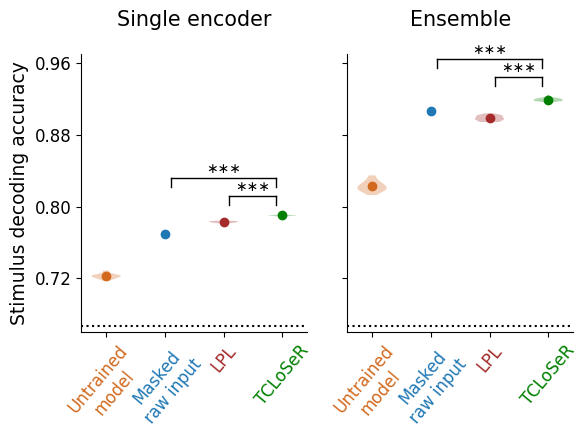

saved figure as figures/9/1_755434585.svg


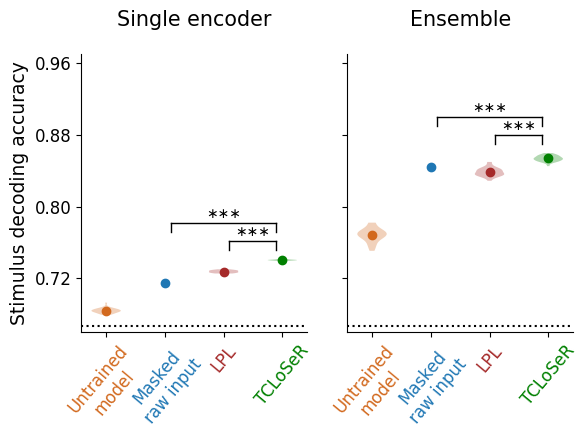

saved figure as figures/9/2_757216464.svg


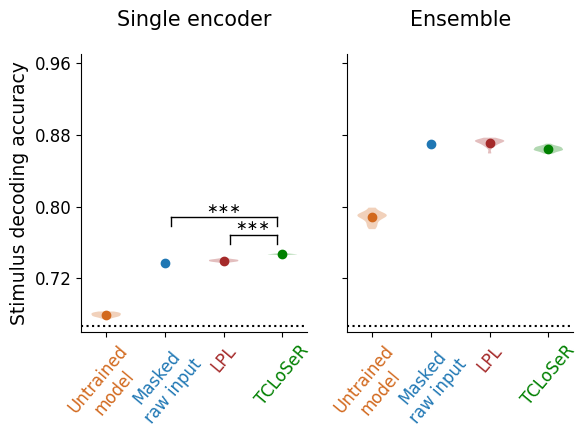

saved figure as figures/9/3_757970808.svg


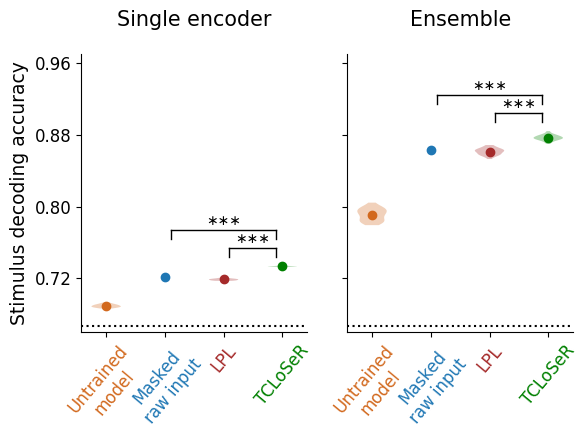

In [61]:
from neuronal.utils.consts import SESSIONS
sign_kwargs = dict(significance_dist=0.02, dist=0.01, dist_from_edges=0.1,)
for i, k in enumerate(ses_and_areas):
    violinplot_model(k, print_missing=True, **sign_kwargs, figsize=(6, 4.5), 
                     ncs=[nc.value for nc in NeuNameAndColors], rotation=50, plot=True, fontsize=13.5, plot_CI=False)
    plt.ylim(0.66, 0.97)
    ses_num = int(k.split("_")[0])
    ses_id = SESSIONS[ses_num]
    savefig(str(i)+ "_" + str(ses_id), 9)   
    plt.show()